In [1]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                8
On-line CPU(s) list:   0-7
Thread(s) per core:    2
Core(s) per socket:    4
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 60
Stepping:              3
CPU MHz:               4303.125
BogoMIPS:              7982.24
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              8192K
NUMA node0 CPU(s):     0-7


In [2]:
!cat /proc/meminfo | head -1

MemTotal:       16373824 kB


In [3]:
from datetime import datetime, timedelta
import functools
import sys
import time

import dask
import dask.distributed
import matplotlib.pyplot as plt
import netCDF4
import numpy
import xarray

from salishsea_tools import evaltools

%matplotlib inline

In [4]:
print(sys.version)
print(xarray.__version__)
print(dask.__version__)
print(netCDF4.__version__)
print(numpy.__version__)

3.7.3 | packaged by conda-forge | (default, Dec  6 2019, 08:54:18) 
[GCC 7.3.0]
0.14.1
2.8.1
1.5.3
1.17.3


In [5]:
j0, j1, i0, i1 = 230, 470, 0, 200

In [6]:
with netCDF4.Dataset("/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc") as mesh:
    tmask=numpy.copy(mesh.variables['tmask'][:,:,j0:j1,i0:i1])
    e3t0=numpy.copy(mesh.variables['e3t_0'][:,:,j0:j1,i0:i1])

In [7]:
flistmuZ = evaltools.index_model_files(
    datetime(2015, 6, 1), datetime(2015, 6, 9),
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/",
    "long", 10, "ptrc_T", 1
)

first file starts on  2015-05-31 00:00:00


In [8]:
flistmuZ['t_0'][0], flistmuZ['t_n'][len(flistmuZ)-1]

(Timestamp('2015-05-31 00:00:00'), Timestamp('2015-06-10 00:00:00'))

In [9]:
def calc_depth_avgs(flist, tmask, e3t0):
    sum1 = numpy.empty((len(flist)*24*10, j1-j0, i1-i0))
    sum1uZ = numpy.empty((len(flist)*24*10, j1-j0, i1-i0))
    for ind, row in flist.iterrows():
        ds = netCDF4.Dataset(row['paths'])
        diatoms = ds.variables['diatoms'][:,:,j0:j1,i0:i1]
        uZ = ds.variables['microzooplankton'][:,:,j0:j1,i0:i1]
        sum1[(24*10*ind):(24*10*(ind+1)),:,:] = numpy.sum(tmask*e3t0*diatoms, 1)
        sum1uZ[(24*10*ind):(24*10*(ind+1)),:,:] = numpy.sum(tmask*e3t0*uZ, 1)
    diatom_int = numpy.mean(sum1, 0)
    microzoo_int = numpy.mean(sum1uZ, 0)
    return diatom_int, microzoo_int

In [10]:
t0=datetime.now()
diatoms_muZ_Int, uZ_muZ_Int = calc_depth_avgs(flistmuZ, tmask, e3t0)
t1=datetime.now()
print(t1-t0)

0:03:45.429268


In [11]:
def calc_depth_avgs_no_loop(flist, tmask, e3t0):
    with netCDF4.Dataset(flist) as ds:
        diatoms = ds.variables['diatoms'][:,:,j0:j1,i0:i1]
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.variables['microzooplankton'][:,:,j0:j1,i0:i1]
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [12]:
t0=datetime.now()
diatoms_int, uZ_int = calc_depth_avgs_no_loop(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    tmask, e3t0)
numpy.testing.assert_equal(diatoms_int, diatoms_muZ_Int)
numpy.testing.assert_equal(uZ_int, uZ_muZ_Int)
t1=datetime.now()
print(t1-t0)

0:02:08.726482


In [13]:
with xarray.open_dataset("/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc") as mesh:
    x_tmask = mesh.tmask.isel(y=slice(j0, j1), x=slice(i0, i1)).data
    x_e3t0 = mesh.e3t_0.isel(y=slice(j0, j1), x=slice(i0, i1)).data

In [14]:
def calc_depth_avgs_xarray(flist, x_tmask, x_e3t0):
    with xarray.open_dataset(flist) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * x_tmask * x_e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * x_tmask * x_e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [15]:
t0=datetime.now()
x_diatoms_int, x_uZ_int = calc_depth_avgs_xarray(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    tmask, e3t0)
numpy.testing.assert_allclose(x_diatoms_int, diatoms_muZ_Int)
numpy.testing.assert_allclose(x_uZ_int, uZ_muZ_Int)
t1=datetime.now()
print(t1-t0)

0:02:03.039396


In [16]:
client = dask.distributed.Client(
    n_workers=2, threads_per_worker=2, processes=True)
client

Client Scheduler: tcp://127.0.0.1:40259 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 16.77 GB


In [17]:
def calc_depth_avgs_dask(flist, chunks, tmask, e3t0):
    with xarray.open_dataset(flist, chunks=chunks) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [18]:
def check_results(diatoms_calc, diatoms_exp, uZ_calc, uZ_exp):
    numpy.testing.assert_allclose(diatoms_calc, diatoms_exp)
    numpy.testing.assert_allclose(uZ_calc, uZ_exp)

In [19]:
chunks = {"time_counter": 1, "deptht": 40, "y": 898, "x": 398}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

In [20]:
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

In [21]:
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

In [22]:
chunks = {"time_counter": 4, "deptht": 40*4, "y": 898*4, "x": 398*4}
d_diatoms_int, d_uZ_int = calc_depth_avgs_dask(
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
    chunks, tmask, e3t0)
check_results(d_diatoms_int, diatoms_muZ_Int, d_uZ_int, uZ_muZ_Int)

In [23]:
flistmuZ = evaltools.index_model_files(
    datetime(2015, 6, 1), datetime(2015, 6, 19),
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/",
    "long", 10, "ptrc_T", 1
)

first file starts on  2015-05-31 00:00:00


In [24]:
flistmuZ

,paths,t_0,t_n
0,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-31,2015-06-10
1,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-10,2015-06-20


In [25]:
t0=datetime.now()
m_diatoms_muZ_Int, m_uZ_muZ_Int = calc_depth_avgs(flistmuZ, tmask, e3t0)
t1=datetime.now()
print(t1-t0)

0:04:25.298556


In [26]:
def calc_depth_avgs_mfdataset(flist, chunks, tmask, e3t0):
    kwargs = dict(combine="nested", concat_dim="time_counter", parallel=True)
    with xarray.open_mfdataset(flist, chunks=chunks, **kwargs) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [27]:
chunks = {"time_counter": 4, "deptht": 40*4, "y": 898*4, "x": 398*4}
mf_diatoms_int, mf_uZ_int = calc_depth_avgs_mfdataset(
    ["/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150531-20150609.nc",
     "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/SalishSea_1h_20150531_20150709_ptrc_T_20150610-20150619.nc",],
    chunks, tmask, e3t0)
check_results(mf_diatoms_int, m_diatoms_muZ_Int, mf_uZ_int, m_uZ_muZ_Int)

In [28]:
client.close()

Final:

In [29]:
with xarray.open_dataset("/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc") as mesh:
    x_tmask = mesh.tmask.isel(y=slice(j0, j1), x=slice(i0, i1)).data
    x_e3t0 = mesh.e3t_0.isel(y=slice(j0, j1), x=slice(i0, i1)).data

In [30]:
flistmuZ = evaltools.index_model_files(
    datetime(2015, 6, 1), datetime(2015, 9, 1),
    "/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/",
    "long", 10, "ptrc_T", 1
)

first file starts on  2015-05-31 00:00:00


In [31]:
flistmuZ

,paths,t_0,t_n
0,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-05-31,2015-06-10
1,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-10,2015-06-20
2,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-20,2015-06-30
3,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-06-30,2015-07-10
4,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-10,2015-07-20
5,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-20,2015-07-30
6,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-07-30,2015-08-09
7,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-08-09,2015-08-19
8,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-08-19,2015-08-29
9,/data/eolson/results/MEOPAR/SS36runs/CedarRuns...,2015-08-29,2015-09-08


In [32]:
flistHC = evaltools.index_model_files(
    flistmuZ['t_0'][0], flistmuZ['t_n'][len(flistmuZ)-1] - timedelta(days=1),
    '/results/SalishSea/hindcast.201905/', 'nowcast', 1, 'ptrc_T', 1)

In [33]:
flistHC

,paths,t_0,t_n
0,/results/SalishSea/hindcast.201905/31may15/Sal...,2015-05-31,2015-06-01
1,/results/SalishSea/hindcast.201905/01jun15/Sal...,2015-06-01,2015-06-02
2,/results/SalishSea/hindcast.201905/02jun15/Sal...,2015-06-02,2015-06-03
3,/results/SalishSea/hindcast.201905/03jun15/Sal...,2015-06-03,2015-06-04
4,/results/SalishSea/hindcast.201905/04jun15/Sal...,2015-06-04,2015-06-05
...,...,...,...
95,/results/SalishSea/hindcast.201905/03sep15/Sal...,2015-09-03,2015-09-04
96,/results/SalishSea/hindcast.201905/04sep15/Sal...,2015-09-04,2015-09-05
97,/results/SalishSea/hindcast.201905/05sep15/Sal...,2015-09-05,2015-09-06
98,/results/SalishSea/hindcast.201905/06sep15/Sal...,2015-09-06,2015-09-07


In [34]:
def calc_depth_avgs_mfdataset(flist, chunks, tmask, e3t0):
    kwargs = dict(combine="nested", concat_dim="time_counter", parallel=True)
    with xarray.open_mfdataset(flist, chunks=chunks, **kwargs) as ds:
        diatoms = ds.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
        diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
        uZ = ds.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
        uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
    return diatoms_int, uZ_int

In [35]:
client = dask.distributed.Client(
    n_workers=2, threads_per_worker=2, processes=True)
client

Client Scheduler: tcp://127.0.0.1:39841 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 16.77 GB


In [36]:
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}

In [37]:
x_diatoms_muZ_int, x_uZ_muZ_int = calc_depth_avgs_mfdataset(
    [row["paths"] for _, row in flistmuZ.iterrows()], chunks, x_tmask, x_e3t0
)

In [38]:
x_diatomsHC_int, x_uZHC_int = calc_depth_avgs_mfdataset(
    [row["paths"] for _, row in flistHC.iterrows()], chunks, x_tmask, x_e3t0
)

In [39]:
t0=datetime.now()
diatomsmuZInt = x_diatoms_muZ_int.compute()
t1=datetime.now()
print(t1-t0)

0:05:07.362480


In [40]:
t0=datetime.now()
diatomsHCInt = x_diatomsHC_int.compute()
t1=datetime.now()
print(t1-t0)

0:04:26.930389


Text(0.5, 1.0, 'Diff')

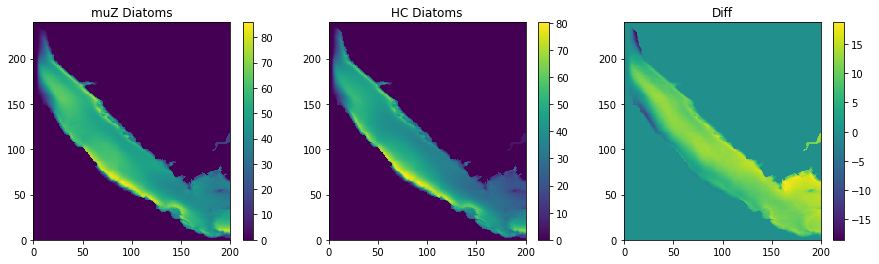

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
m0 = ax[0].pcolormesh(diatomsmuZInt)
plt.colorbar(m0, ax=ax[0])
ax[0].set_title('muZ Diatoms')
m1 = ax[1].pcolormesh(diatomsHCInt)
plt.colorbar(m1,ax=ax[1])
ax[1].set_title('HC Diatoms')
m2 = ax[2].pcolormesh(diatomsmuZInt - diatomsHCInt)
plt.colorbar(m2,ax=ax[2])
ax[2].set_title('Diff')

In [42]:
t0=datetime.now()
uZmuZInt = x_uZ_muZ_int.compute()
t1=datetime.now()
print(t1-t0)

0:05:02.563986


In [43]:
t0=datetime.now()
uZHCInt = x_uZHC_int.compute()
t1=datetime.now()
print(t1-t0)

0:04:22.003628


Text(0.5, 1.0, 'Diff')

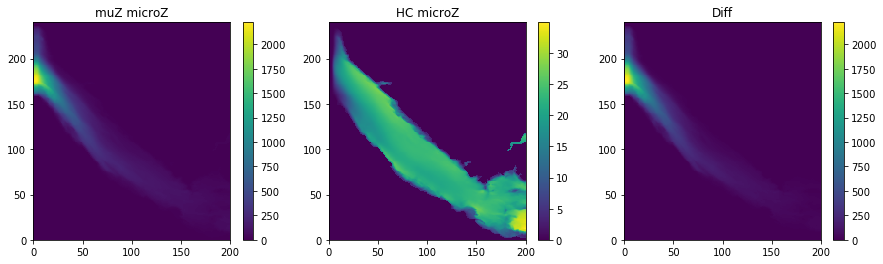

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
m0 = ax[0].pcolormesh(uZmuZInt)
plt.colorbar(m0, ax=ax[0])
ax[0].set_title('muZ microZ')
m1 = ax[1].pcolormesh(uZHCInt)
plt.colorbar(m1,ax=ax[1])
ax[1].set_title('HC microZ')
m2 = ax[2].pcolormesh(uZmuZInt - uZHCInt)
plt.colorbar(m2,ax=ax[2])
ax[2].set_title('Diff')

In [45]:
client.close()